Código adaptador de:
* https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
import pandas as pd

In [3]:
import os

pasta = "dataset/"

def files_path04(path):
    infos =[]
    for p, _, files in os.walk(os.path.abspath(path)):
        for file in files:
            infos.append(os.path.join(p, file))
    return infos

dados = files_path04(pasta)

In [4]:
tipo = [i.split("\\")[-3] for i in dados]
subgroup = [i.split("\\")[-2] for i in dados]
filename = [i.split("\\")[-1] for i in dados]
classe = [0 if x == "benigno" else 1 for x in tipo  ]

In [5]:
df = pd.DataFrame()

In [6]:
df['filename'] = filename
df['subgroup'] = subgroup
df['tipo'] = tipo
df['classe'] = classe

In [7]:
df

,filename,subgroup,tipo,classe
0,benigno10.png,1,benigno,0
1,benigno11.png,1,benigno,0
2,benigno12.png,1,benigno,0
3,benigno13.png,1,benigno,0
4,benigno1046.png,10,benigno,0
...,...,...,...,...
2687,maligno982.png,98,maligno,1
2688,maligno983.png,98,maligno,1
2689,maligno990.png,99,maligno,1
2690,maligno991.png,99,maligno,1


In [8]:
benignos_sub = df[df['tipo']=='benigno']['subgroup'].unique()
malignos_sub = df[df['tipo']=='maligno']['subgroup'].unique()

In [9]:
import random
random.seed(42)

In [10]:
random.shuffle(benignos_sub)
random.shuffle(malignos_sub)

In [11]:
def split(lista, folds):
    index=[]
    pivo = int(len(lista)/folds)
    for i in range(folds+1):
        index.append(lista[i*pivo:pivo*(i+1)])
    return index

folds = 14
index_benignos = split(benignos_sub,folds)
index_malignos = split(malignos_sub,folds)

In [12]:
width = 64
height = 64
IMAGE_SIZE = (width,height)
num_densa = 256
channels = 3
num_out = 1

In [13]:
import cv2

In [14]:
import numpy as np

In [15]:

def images_labels(indexs,tipo):
    first = True
    for i in indexs:

        imagens = df[(df['subgroup']==i)& (df['tipo']==tipo)]['filename'].values
        X_train = np.zeros((len(imagens), width, height, channels))

        for idx,j in  enumerate(imagens):
            X_train[idx] =  np.asarray(cv2.resize(cv2.imread(pasta+tipo+"/"+i+"/"+j), (64,64), interpolation = cv2.INTER_AREA))

        X_train = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255. 
        if first:
            out = X_train
        else:
            out = np.concatenate((X_train,out))  
        first = False
    return out
    

In [16]:
def concat_treino_idx(accessed_list):
    out =[]
    for i in accessed_list:
        for j in i:
            out.append(j)
    return out

In [17]:
def images_por_fold(index_benignos,treino_idx,teste_idx,val_idx,tipo):
    treino_idx.remove(val_idx)
    treino_idx.remove(teste_idx)
    accessed_mapping = map(index_benignos.__getitem__, treino_idx)
    accessed_list = list(accessed_mapping)
    treino_idx = concat_treino_idx(accessed_list)
    
    treino = images_labels(treino_idx,tipo)
    val = images_labels(index_benignos[val_idx],tipo)
    teste = images_labels(index_benignos[teste_idx],tipo)
    return treino,val,teste

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
from tensorflow.keras.applications import efficientnet

def get_cnn_efficientnet():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, channels), include_top=False,
    )

    base_model.trainable = True
    base_model_out = base_model.output
    base_model_out = layers.Flatten()(base_model_out)
    base_model_out = layers.Dense(num_densa, activation="relu")(base_model_out)
    base_model_out = layers.Dense(num_out, activation="sigmoid")(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


from tensorflow.keras.applications.vgg19 import VGG19

def get_cnn_VGG19():
    base_model = VGG19(
        input_shape=(*IMAGE_SIZE, channels), include_top=False,
    )

    base_model.trainable = True
    base_model_out = base_model.output
    base_model_out = layers.Flatten()(base_model_out)
    base_model_out = layers.Dense(num_densa, activation="relu")(base_model_out)
    base_model_out = layers.Dense(num_out, activation="sigmoid")(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

from tensorflow.keras.applications.resnet50 import ResNet50

def get_cnn_ResNet50():
    base_model = ResNet50(
        input_shape=(*IMAGE_SIZE, channels), include_top=False,
    )

    base_model.trainable = True
    base_model_out = base_model.output
    base_model_out = layers.Flatten()(base_model_out)
    base_model_out = layers.Dense(num_densa, activation="relu")(base_model_out)
    base_model_out = layers.Dense(num_out, activation="sigmoid")(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [21]:
val_idx = 1
teste_idx = 2

for i in range(folds):
    #ler dados
    tipo = "benigno"
    treino_idx = [item for item in range(folds)]
    treino_b,val_b,teste_b = images_por_fold(index_benignos,treino_idx,teste_idx,val_idx,tipo)
    treino_b_label = np.repeat(0, len(treino_b))
    val_b_label = np.repeat(0, len(val_b))
    teste_b_label = np.repeat(0, len(teste_b))
    
    tipo = "maligno"
    treino_idx = [item for item in range(folds)]
    treino_m,val_m,teste_m = images_por_fold(index_malignos,treino_idx,teste_idx,val_idx,tipo)
    treino_m_label = np.repeat(1, len(treino_m))
    val_m_label = np.repeat(1, len(val_m))
    teste_m_label = np.repeat(1, len(teste_m))
    
    X_train = np.concatenate((treino_b,treino_m))
    y_train = np.concatenate((treino_b_label,treino_m_label))
    
    X_val = np.concatenate((val_b,val_m))
    y_val = np.concatenate((val_b_label,val_m_label))
    
    #Cortando o malignos para ficar igual
    X_teste = np.concatenate((teste_b,teste_m[:len(teste_b)]))
    y_teste = np.concatenate((teste_b_label,teste_m_label[:len(teste_b_label)]))
    
    datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=30,zoom_range=[0.1,1.0])
    it = datagen.flow(X_train, y_train, batch_size=10000)
    data = next(it)
    
    X_train = np.concatenate((X_train,data[0]))
    y_train = np.concatenate((y_train,data[1]))
    
    
    #execução modelos um aqui

    #função do calculo das métricas
    
    
    #update folds

    val_idx = val_idx + 1
    if val_idx> folds:
        val_idx = 0
    teste_idx = teste_idx + 1
    if teste_idx> folds:
        teste_idx = 0
    break

# VIT

In [22]:
num_classes = 2
input_shape = (64, 64, 3)

In [23]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [27]:
import matplotlib.pyplot as plt

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 108


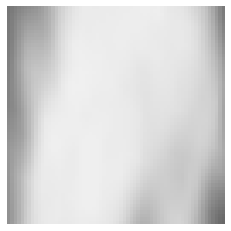

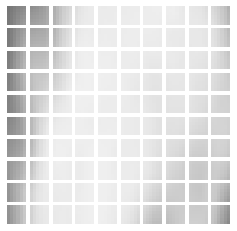

In [28]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [29]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [30]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [31]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

   # checkpoint_filepath = "/tmp/checkpoint"
    #checkpoint_callback = keras.callbacks.ModelCheckpoint(
     #   checkpoint_filepath,
      #  monitor="val_accuracy",
       # save_best_only=True,
        #save_weights_only=True,
   # )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        #validation_split=0.1,
        callbacks=[es],
    )

  #  model.load_weights(checkpoint_filepath)
   # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [32]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
18/18 [==============================] - 12s 266ms/step - loss: 1.5338 - accuracy: 0.6645 - val_loss: 0.6248 - val_accuracy: 0.6154
Epoch 2/100
18/18 [==============================] - 4s 210ms/step - loss: 0.6105 - accuracy: 0.7184 - val_loss: 0.5540 - val_accuracy: 0.8242
Epoch 3/100
18/18 [==============================] - 4s 209ms/step - loss: 0.5824 - accuracy: 0.7252 - val_loss: 0.5632 - val_accuracy: 0.7527
Epoch 4/100
18/18 [==============================] - 4s 207ms/step - loss: 0.5815 - accuracy: 0.7301 - val_loss: 0.5640 - val_accuracy: 0.5714
Epoch 4: early stopping


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

     Benigno       0.82      0.26      0.39        54
     Maligno       0.56      0.94      0.70        54

    accuracy                           0.60       108
   macro avg       0.69      0.60      0.55       108
weighted avg       0.69      0.60      0.55       108



<AxesSubplot:>

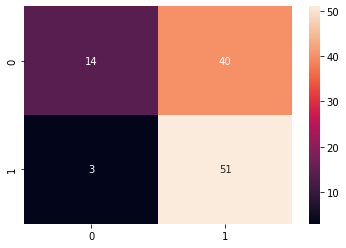

In [34]:
threshold =0.5
y_pred = np.where(vit_classifier.predict(X_teste)> threshold, 1,0)
target_names = ['Benigno', "Maligno"]
print(classification_report(y_teste, y_pred, target_names=target_names))
cf_matrix = confusion_matrix(y_teste, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,fmt="g")